In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from category_encoders.target_encoder import TargetEncoder
import umap
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import shap
import pickle

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12704\3443027451.py:12: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [93]:
class Preprocessor:
    def __init__(self, numerical_impute_strategy, categorical_impute_strategy, roll_cols, roll_strategies, roll_period):
        if len(roll_cols) != len(roll_strategies):
            raise ValueError('Value Error: len(roll_cols) != len(roll_strategies).')
        self.locations = None
        self.numerical_impute_strategy = numerical_impute_strategy
        self.categorical_impute_strategy = categorical_impute_strategy
        self.roll_cols = roll_cols
        self.roll_strategies = roll_strategies
        self.roll_period = roll_period

    def preprocess(self, _data, visualize=False):
        data = _data.copy(deep=True)

        for column in ['RainToday', 'RainTomorrow']:
            data.loc[data[column] == 'Yes', column] = 1
            data.loc[data[column] == 'No', column] = 0

        data['Year'] = pd.DatetimeIndex(data['Date']).year
        data['Month'] = pd.DatetimeIndex(data['Date']).month

        if not visualize:
            self.impute(data)

        data['Location'] = data['Location'].apply(lambda loc: ' '.join(re.findall('[A-Z][^A-Z]+|[A-Z]+', loc)))
        data.loc[data.Location == 'Portland', 'Location'] = 'Portland, Victoria'
        data.loc[data.Location == 'Dartmoor', 'Location'] = 'Dartmoor, Victoria'
        data.loc[data.Location == 'Perth', 'Location'] = 'Perth, Western Australia'
        data.loc[data.Location == 'Richmond', 'Location'] = 'Richmond, New South Wales'
        data['Location'] = data.Location + ', Australia'

        if self.locations is None:
            geolocator = Nominatim(user_agent="rain-in-australia-app")
            locations = {'Location_reduced': [], 'Location': [], 'Address': [], 'Latitude': [], 'Longitude': []}
            for location in data.Location.unique().tolist() + ['Australia']:
                location_enc = geolocator.geocode(location, language='en')
                if location_enc is None:
                    raise ValueError(f'Location not found: {location}')
                locations['Location_reduced'] += [location.split(', ')[0]]
                locations['Location'] += [location]
                locations['Address'] += [location_enc.address]
                locations['Latitude'] += [location_enc.latitude]
                locations['Longitude'] += [location_enc.longitude]
            self.locations = pd.DataFrame(locations)
        data = data.merge(self.locations[['Location', 'Latitude', 'Longitude']], left_on='Location',
                          right_on='Location')

        if visualize:
            data['Location'] = data['Location'].apply(lambda loc: loc.split(', ')[0])

        data = self.RainToday_Locations(data)

        if not visualize:
            data = self.target_encoding(data)

        for i, col in enumerate(self.roll_cols):
            data[f'{col}_{self.roll_period}days'] = Preprocessor.rolling_features_for_all_locations(data[col],
                                                                                                    data.Location,
                                                                                                    period=self.roll_period,
                                                                                                    shift=1,
                                                                                                    strategy=
                                                                                                    self.roll_strategies[
                                                                                                        i])

        acc_col = [column for column in data.columns if 'RainToday_' in column and 'days' not in column or column == 'Month_Location']
        data['Accumulated_probabilities'] = data.loc[:, acc_col].sum(axis=1)
        return data

    def impute(self, data):
        columns = data.columns[2:-2]
        dtypes = data.dtypes[2:-2]
        numerical = [column for idx, column in enumerate(columns) if dtypes[idx] == float]
        categorical = [column for idx, column in enumerate(columns) if dtypes[idx] == object]
        if self.numerical_impute_strategy == 'mean':
            data[numerical] = data.groupby(['Month', 'Location'])[numerical].transform(lambda x: x.fillna(x.mean()))
        elif self.numerical_impute_strategy == 'median':
            data[numerical] = data.groupby(['Month', 'Location'])[numerical].transform(lambda x: x.fillna(x.median()))
        else:
            raise ValueError('Wrong numerical impute strategy.')

        if self.categorical_impute_strategy == 'mode':
            data[categorical] = data.groupby(['Month', 'Location'])[categorical].transform(lambda x: x.fillna(x.mode()))
        else:
            raise ValueError('Wrong categorical impute strategy.')

    def RainToday_Locations(self, data):
        grouped = data.groupby('Date')[['Location', 'RainToday']].apply(lambda r: r.set_index('Location').T)
        grouped = grouped.reset_index().drop('level_1', axis=1)
        if ',' in grouped.columns[1]:
            grouped.columns = ['Date'] + ['RainToday_' + col[:col.index(',')] for col in grouped.columns[1:]]
        else:
            grouped.columns = ['Date'] + ['RainToday_' + col for col in grouped.columns[1:]]
        return data.merge(grouped, left_on='Date', right_on='Date')

    def target_encoding(self, _data):
        data = _data.copy(deep=True)
        data['Month_Location'] = data['Month']
        location_cols = [column for column in data.columns if 'RainToday_' in column] + ['WindGustDir', 'WindDir9am',
                                                                                         'WindDir3pm', 'Month_Location']

        for location in data.Location.unique():
            location_encoder = TargetEncoder(cols=location_cols, handle_missing=0)
            location_df = data.loc[data.Location == location]
            data.loc[data.Location == location] = location_encoder.fit_transform(location_df, location_df.RainTomorrow)

        location_encoder = TargetEncoder(cols=['Location', 'Month'])
        encoded = location_encoder.fit_transform(data, data.RainTomorrow)

        for c in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            encoded[c] = encoded[c].astype(float)
        return encoded

    @staticmethod
    def rolling_features_for_all_locations(series_, locations, period, shift, strategy):

        def rolling_features_for_location(series_, period, shift, strategy):
            first_n = []
            for i in range(period):
                if i == 0:
                    first_n += [series_[i]]
                else:
                    if strategy == 'mean':
                        first_n += [series_[:i + 1 - shift].mean()]
                    elif strategy == 'median':
                        first_n += [series_[:i + 1 - shift].median()]
                    elif strategy == 'sum':
                        first_n += [series_[:i + 1 - shift].sum()]
                    else:
                        raise ValueError('Wrong strategy.')

            if strategy == 'mean':
                new_series = series_.shift(shift).rolling(period).mean()
            elif strategy == 'median':
                new_series = series_.shift(shift).rolling(period).median()
            elif strategy == 'sum':
                new_series = series_.shift(shift).rolling(period).sum()
            else:
                raise ValueError('Wrong strategy.')

            new_series[:period] = first_n
            return new_series

        all_locations = []
        for location in locations.unique():
            one_location, index = series_[locations == location].reset_index(drop=True, inplace=False), series_[
                locations == location].index.to_series()
            new_series_for_location = rolling_features_for_location(one_location, period, shift, strategy)
            new_series_for_location.index = index
            all_locations += [new_series_for_location]
        return pd.concat(all_locations, axis=0)

    @staticmethod
    def load_and_split():
        dataset = pd.read_csv('data/weatherAUS.csv')
        dataset.sort_values(['Date', 'Location'], inplace=True)
        dataset.reset_index(drop=True, inplace=True)
        train, test = dataset.iloc[:109103], dataset.iloc[109103:]
        return train, test


In [94]:
standard_roll_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                      'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                      'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                      'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
standard_roll_strategies = ['mean'] * (len(standard_roll_cols) - 1) + ['sum']
standard_roll_period = 7

In [95]:
preprocessor = Preprocessor('median', 'mode', standard_roll_cols, standard_roll_strategies, standard_roll_period)
train, test = preprocessor.load_and_split()
train_prep = preprocessor.preprocess(train, visualize=False)

Mean of empty slice
Mean of empty slice


In [96]:
train_prep

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am_7days,Humidity3pm_7days,Pressure9am_7days,Pressure3pm_7days,Cloud9am_7days,Cloud3pm_7days,Temp9am_7days,Temp3pm_7days,RainToday_7days,Accumulated_probabilities
0,2007-11-01,0.179851,8.0,24.3,0.0,3.4,6.3,0.180401,30.0,0.213197,...,68.000000,29.000000,1019.700000,1015.000000,7.000000,7.000000,14.400000,23.600000,0.0,9.631074
1,2007-11-02,0.179851,14.0,26.9,3.6,4.4,9.7,0.123810,39.0,0.198196,...,68.000000,29.000000,1019.700000,1015.000000,7.000000,7.000000,14.400000,23.600000,0.0,9.837981
2,2007-11-03,0.179851,13.7,23.4,3.6,5.8,3.3,0.180401,85.0,0.254777,...,74.000000,32.500000,1016.050000,1011.700000,6.000000,5.000000,15.950000,24.650000,1.0,9.837981
3,2007-11-04,0.179851,13.3,15.5,39.8,7.2,9.1,0.180401,54.0,0.116789,...,76.666667,44.666667,1013.866667,1010.200000,6.666667,5.666667,15.766667,23.166667,2.0,9.837981
4,2007-11-05,0.179851,7.6,16.1,2.8,5.6,10.6,0.159013,50.0,0.198347,...,73.000000,47.500000,1011.775000,1009.400000,5.500000,6.000000,15.200000,20.900000,3.0,9.837981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109098,2015-06-14,0.296763,4.2,15.6,0.8,NaN,NaN,0.174999,37.0,0.244444,...,81.285714,69.428571,1024.242857,1022.328571,NaN,NaN,14.200000,17.128571,NaN,14.544409
109099,2015-06-14,0.067316,13.3,16.2,0.0,3.2,7.5,0.083045,33.0,0.039773,...,71.571429,45.857143,1027.771429,1025.442857,3.571429,2.571429,10.557143,17.342857,0.0,3.371986
109100,2015-06-14,0.157641,18.9,33.2,0.0,4.0,NaN,0.118566,28.0,0.157859,...,67.714286,41.285714,1015.628571,1011.671429,2.000000,3.571429,23.342857,30.657143,0.0,8.063371
109101,2015-06-14,0.153197,5.5,16.6,0.0,NaN,NaN,0.247560,20.0,0.126616,...,98.571429,56.000000,1029.057143,1026.628571,NaN,NaN,7.328571,15.114286,0.0,7.457778


In [97]:
train_prep.drop('Date', axis=1, inplace=True)
train_X, train_y = train_prep.drop('RainTomorrow', axis=1), train_prep.RainTomorrow
fixed_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [103]:
lgb_params = {

    "objective": "binary",
    "learning_rate": 0.05,
    "num_threads": 10,
    "metric": "AUC",
    "seed": 42,
   "verbose":-1,
    'class_weight': 'balanced',
    
     #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.8,

    "subsample_freq": 1,
    "min_data_in_leaf": 300,

    "num_leaves":10,
    
    "n_estimators":10_000
    
    #categorical features
#     'cat_smooth': 5,
#     'min_data_per_group': 2
#     did not improve the results
    
}
lgb_train = lgb.Dataset(train_X, label=train_y.fillna(0), free_raw_data=False)
result = lgb.cv(lgb_params, lgb_train, 10_000, folds=fixed_skf, callbacks=[lgb.early_stopping(15), lgb.log_evaluation(15)], eval_train_metric=True, return_cvbooster=True)
lgb_params['n_estimators'] = result["cvbooster"].best_iteration

Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 15 rounds
[15]	cv_agg's train auc: 0.862448 + 0.000667586	cv_agg's valid auc: 0.860103 + 0.00256168
[30]	cv_agg's train auc: 0.870747 + 0.000462061	cv_agg's valid auc: 0.867786 + 0.00253409
[45]	cv_agg's train auc: 0.876225 + 0.000436815	cv_agg's valid auc: 0.872889 + 0.00260898
[60]	cv_agg's train auc: 0.880668 + 0.000374248	cv_agg's valid auc: 0.876963 + 0.00258235
[75]	cv_agg's train auc: 0.884698 + 0.000378101	cv_agg's valid auc: 0.880739 + 0.00266463
[90]	cv_agg's train auc: 0.887905 + 0.000430349	cv_agg's valid auc: 0.883592 + 0.00257419
[105]	cv_agg's train auc: 0.890363 + 0.000454864	cv_agg's valid auc: 0.885643 + 0.00254555
[120]	cv_agg's train auc: 0.892455 + 0.00043898	cv_agg's valid auc: 0.887387 + 0.00260801
[135]	cv_agg's train auc: 0.894144 + 0.000421722	cv_agg's valid auc: 0.888776 + 0.0026011
[150]	cv_agg's train auc: 0.895696 + 0.000441604	cv_agg's valid auc: 0.889995 + 0.00249452
[165]	cv_agg's train auc: 0.897027 + 

[1365]	cv_agg's train auc: 0.935248 + 0.000501734	cv_agg's valid auc: 0.905741 + 0.00197603
[1380]	cv_agg's train auc: 0.935548 + 0.000478308	cv_agg's valid auc: 0.905779 + 0.0020008
[1395]	cv_agg's train auc: 0.935852 + 0.000498884	cv_agg's valid auc: 0.905825 + 0.00197086
[1410]	cv_agg's train auc: 0.936132 + 0.000482215	cv_agg's valid auc: 0.905889 + 0.00195718
[1425]	cv_agg's train auc: 0.936447 + 0.000481674	cv_agg's valid auc: 0.905926 + 0.00195059
[1440]	cv_agg's train auc: 0.936732 + 0.000468671	cv_agg's valid auc: 0.905991 + 0.00196607
[1455]	cv_agg's train auc: 0.937037 + 0.000480104	cv_agg's valid auc: 0.906043 + 0.00190638
[1470]	cv_agg's train auc: 0.937323 + 0.000471081	cv_agg's valid auc: 0.906076 + 0.00192633
[1485]	cv_agg's train auc: 0.937636 + 0.000460426	cv_agg's valid auc: 0.906103 + 0.00191123
[1500]	cv_agg's train auc: 0.937926 + 0.000446566	cv_agg's valid auc: 0.906149 + 0.00191504
[1515]	cv_agg's train auc: 0.938207 + 0.000438777	cv_agg's valid auc: 0.906205 + 

In [52]:
result.pop('cvbooster')

In [54]:
pd.DataFrame(result)[['train auc-mean', 'valid auc-mean']].iloc[-1]

train auc-mean    0.863590
valid auc-mean    0.828799
Name: 297, dtype: float64

In [106]:
def cond(x):
    return x[1] > 0 and ('RainToday_' in x[0] and 'days' not in x[0])

In [107]:
relevant_cities = {}
for location in train.Location.unique():
    train_X_loc = train_X.loc[train.Location == location]
    train_y_loc = train_y.loc[train_X_loc.index]
    lgb_clf = lgb.LGBMClassifier(**lgb_params)
    lgb_clf.fit(train_X_loc, train_y_loc.fillna(0))
    explainer = shap.TreeExplainer(lgb_clf, train_X_loc, model_output="probability")
    shap.initjs()
    shap_values = explainer.shap_values(train_X_loc)
    ce = np.c_[train_X.columns, np.abs(shap_values).mean(axis=0)]
    applied = np.apply_along_axis(cond, 1, ce)
    relevant_cities[location] = ce[applied, 0]
    print(f'Location:{location}')

100%|===================| 2690/2694 [01:18<00:00]        

Location:Canberra
train auc-mean    0.948998
valid auc-mean    0.907765
Name: 2160, dtype: float64


 99%|===================| 2588/2602 [01:09<00:00]        

Location:Sydney


KeyError: 'cvbooster'

In [57]:
lgb_clf = lgb.LGBMClassifier(**lgb_params)
lgb_clf.fit(train_X_loc, train_y_loc.fillna(0))
explainer = shap.TreeExplainer(lgb_clf, train_X_loc, model_output="probability")
shap.initjs()
shap_values = explainer.shap_values(train_X_loc)

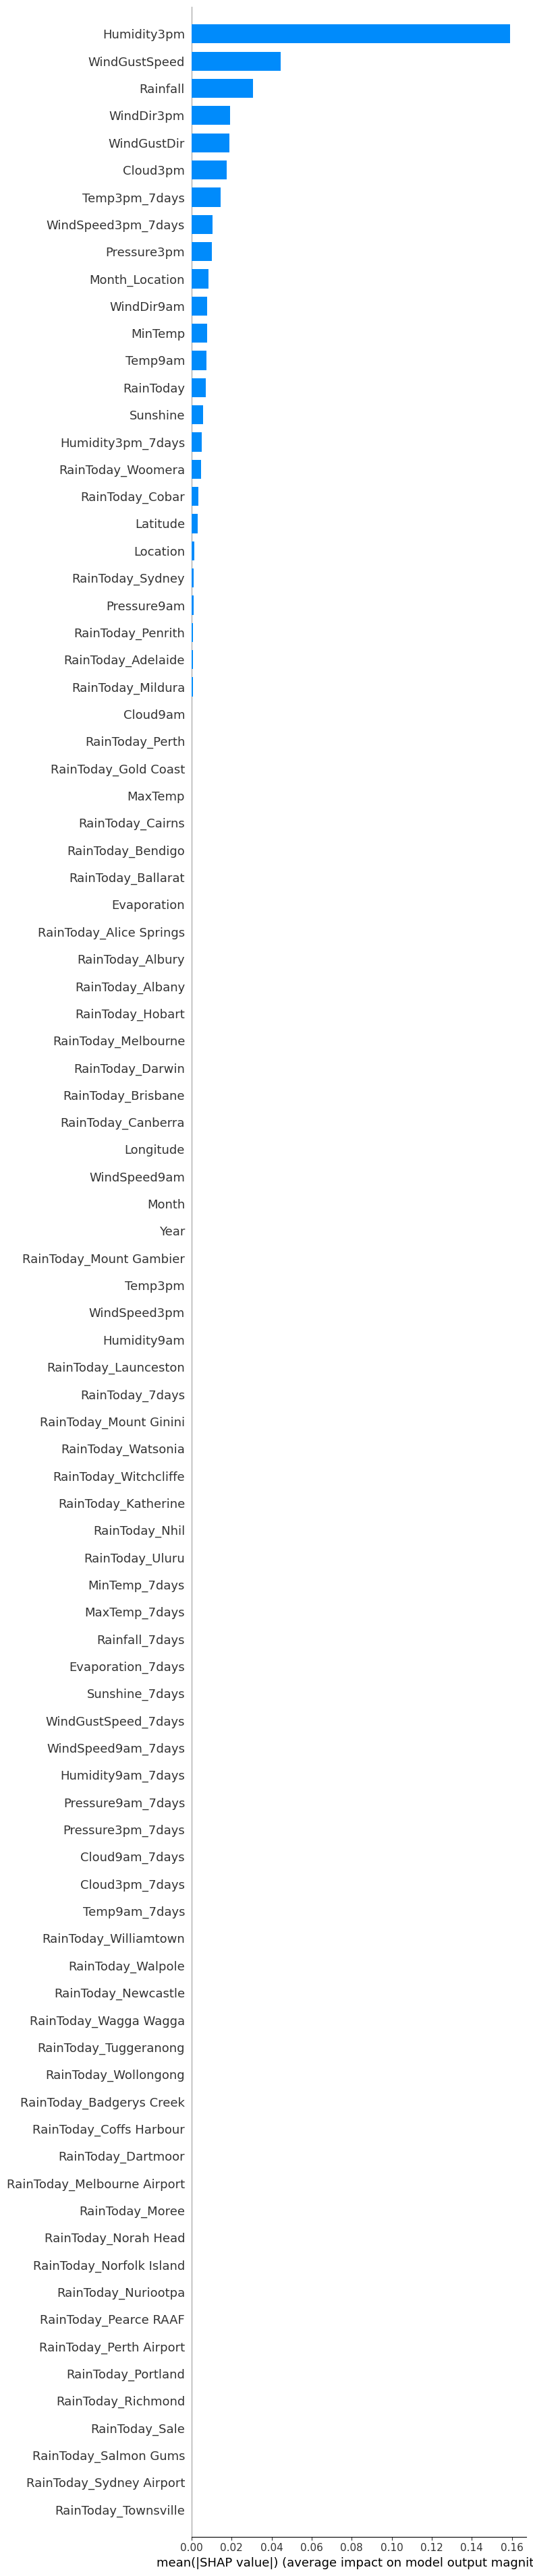

In [56]:
shap.summary_plot(shap_values, train_X, plot_type='bar', max_display=train_X_loc.shape[1])

In [104]:
ce = np.c_[train_X.columns, np.abs(shap_values).mean(axis=0)]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 93 and the array at index 1 has size 92

In [69]:
def cond(x):
    return x[1] > 0 and ('RainToday_' in x[0] and 'days' not in x[0])

In [70]:
applied = np.apply_along_axis(cond, 1, ce)

In [73]:
ce[applied, 0]

array(['RainToday_Sydney', 'RainToday_Adelaide', 'RainToday_Perth',
       'RainToday_Bendigo', 'RainToday_Mount Ginini', 'RainToday_Penrith',
       'RainToday_Cobar', 'RainToday_Mildura', 'RainToday_Moree',
       'RainToday_Sale', 'RainToday_Walpole', 'RainToday_Williamtown',
       'RainToday_Woomera', 'Rainfall_7days', 'WindGustSpeed_7days',
       'WindSpeed3pm_7days', 'Humidity9am_7days', 'RainToday_7days'],
      dtype=object)

In [72]:
ce

array([['Location', 0.0],
       ['MinTemp', 0.02557361050570609],
       ['MaxTemp', 0.0],
       ['Rainfall', 0.041389769115662764],
       ['Evaporation', 0.0],
       ['Sunshine', 0.0],
       ['WindGustDir', 0.04229976819931583],
       ['WindGustSpeed', 0.035343874599748276],
       ['WindDir9am', 0.00971992337890656],
       ['WindDir3pm', 0.031047693643469116],
       ['WindSpeed9am', 0.0015476699511861403],
       ['WindSpeed3pm', 0.00857410796886268],
       ['Humidity9am', 0.00642895866532557],
       ['Humidity3pm', 0.10282280145247982],
       ['Pressure9am', 0.0],
       ['Pressure3pm', 0.0],
       ['Cloud9am', 0.001510142633729447],
       ['Cloud3pm', 0.03518288479119824],
       ['Temp9am', 0.011260717811762334],
       ['Temp3pm', 0.0017581632145905444],
       ['RainToday', 0.0072969997884192285],
       ['Year', 0.0],
       ['Month', 0.0],
       ['Latitude', 0.0],
       ['Longitude', 0.0],
       ['RainToday_Canberra', 0.0],
       ['RainToday_Sydney', 0.0044347

In [77]:
train_X_loc.columns.sort_values()

Index(['Cloud3pm', 'Cloud3pm_7days', 'Cloud9am', 'Cloud9am_7days',
       'Evaporation', 'Evaporation_7days', 'Humidity3pm', 'Humidity3pm_7days',
       'Humidity9am', 'Humidity9am_7days', 'Latitude', 'Location', 'Longitude',
       'MaxTemp', 'MaxTemp_7days', 'MinTemp', 'MinTemp_7days', 'Month',
       'Month_Location', 'Pressure3pm', 'Pressure3pm_7days', 'Pressure9am',
       'Pressure9am_7days', 'RainToday', 'RainToday_7days',
       'RainToday_Adelaide', 'RainToday_Albany', 'RainToday_Albury',
       'RainToday_Alice Springs', 'RainToday_Badgerys Creek',
       'RainToday_Ballarat', 'RainToday_Bendigo', 'RainToday_Brisbane',
       'RainToday_Cairns', 'RainToday_Canberra', 'RainToday_Cobar',
       'RainToday_Coffs Harbour', 'RainToday_Dartmoor', 'RainToday_Darwin',
       'RainToday_Gold Coast', 'RainToday_Hobart', 'RainToday_Katherine',
       'RainToday_Launceston', 'RainToday_Melbourne',
       'RainToday_Melbourne Airport', 'RainToday_Mildura', 'RainToday_Moree',
       'RainT

In [78]:
train_prep['Accumulated_probabilities'] = train_prep.iloc[:, 27:-18].sum(axis=1)

In [89]:
[column for column in train_prep.columns if 'RainToday_' in column and 'days' not in column or column == 'Month_Location']

['RainToday_Canberra',
 'RainToday_Sydney',
 'RainToday_Adelaide',
 'RainToday_Brisbane',
 'RainToday_Darwin',
 'RainToday_Hobart',
 'RainToday_Melbourne',
 'RainToday_Perth',
 'RainToday_Albany',
 'RainToday_Albury',
 'RainToday_Alice Springs',
 'RainToday_Ballarat',
 'RainToday_Bendigo',
 'RainToday_Cairns',
 'RainToday_Gold Coast',
 'RainToday_Launceston',
 'RainToday_Mount Gambier',
 'RainToday_Mount Ginini',
 'RainToday_Newcastle',
 'RainToday_Penrith',
 'RainToday_Townsville',
 'RainToday_Tuggeranong',
 'RainToday_Wollongong',
 'RainToday_Badgerys Creek',
 'RainToday_Cobar',
 'RainToday_Coffs Harbour',
 'RainToday_Dartmoor',
 'RainToday_Melbourne Airport',
 'RainToday_Mildura',
 'RainToday_Moree',
 'RainToday_Norah Head',
 'RainToday_Norfolk Island',
 'RainToday_Nuriootpa',
 'RainToday_Pearce RAAF',
 'RainToday_Perth Airport',
 'RainToday_Portland',
 'RainToday_Richmond',
 'RainToday_Sale',
 'RainToday_Salmon Gums',
 'RainToday_Sydney Airport',
 'RainToday_Wagga Wagga',
 'RainTod